In [59]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

import sys
import logging

from scipy.io import arff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skmultiflow.data import DataStream
from scipy import stats

#from util import run_performance_experiment, plot_performance_comparison, print_evaluation, gridsearch_adwin_parameter, plot_drift_detection_summary
#from Detection_Strategies import adwin_uncertainty, adwin_error, uninformed, ks_data, no_retraining, equal_distribution
import pickle

%load_ext autoreload
%autoreload 2

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
filename = 'results_MCDropout_mixed.pickle'
results = pickle.load(open(filename, 'rb'))

In [61]:
results.keys()

dict_keys(['metrics', 'errors', 'drifts', 'raw'])

In [62]:
raw = results['raw']

In [63]:
uncertainties = raw['adwin_uncertainty 0']['uncertainties']
detected_drifts = results['drifts']['adwin_uncertainty 0']
ks_drifts = results['drifts']['kswin_unlimited']
adwin_error = results['drifts']['adwin_error']

In [64]:
rel_drift_points = np.array([2000, 3000, 7000, 9000, 17500])
irrel_drift_points = np.array([10000, 12500])
stream_training_set_size = 20000 * 0.15
shift_rel_drift_points = (rel_drift_points - stream_training_set_size).astype(int)
shift_irrel_drift_points = (irrel_drift_points - stream_training_set_size).astype(int)

In [65]:
relevant_drift_points = [i for i in shift_rel_drift_points if i>0]
irrelevant_drift_points = [i for i in shift_irrel_drift_points if i>0]

In [66]:
type(uncertainties)

pandas.core.series.Series

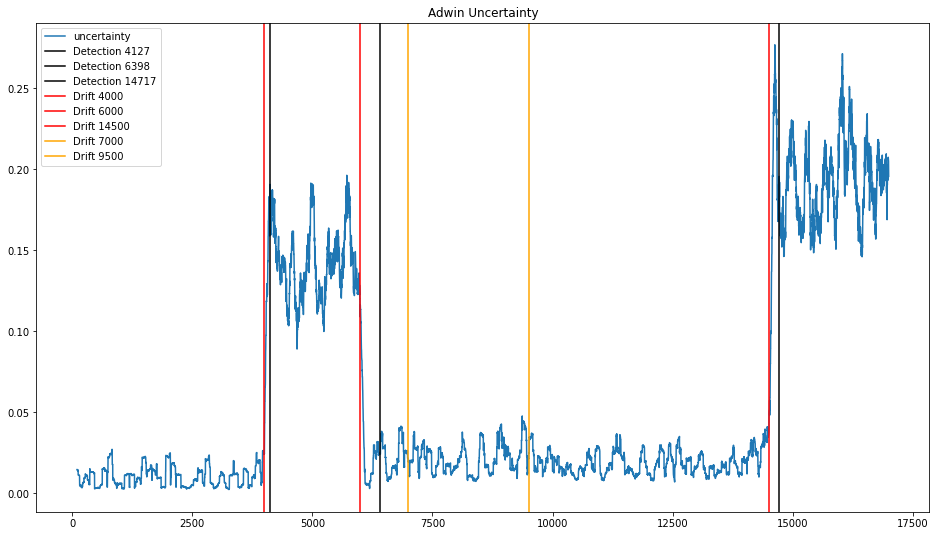

In [67]:
plt.figure(figsize = (16,9))
plt.plot(uncertainties.rolling(window = 100).mean(), label = 'uncertainty')
for i in detected_drifts:
    plt.axvline(i, color = 'black', label = 'Detection {}'.format(i))
    
for i in relevant_drift_points:
    plt.axvline(i, color = 'red', label = 'Drift {}'.format(i))
    
for i in irrelevant_drift_points:
    plt.axvline(i, color = 'orange', label = 'Drift {}'.format(i))

plt.title('Adwin Uncertainty')
plt.legend()
plt.show()

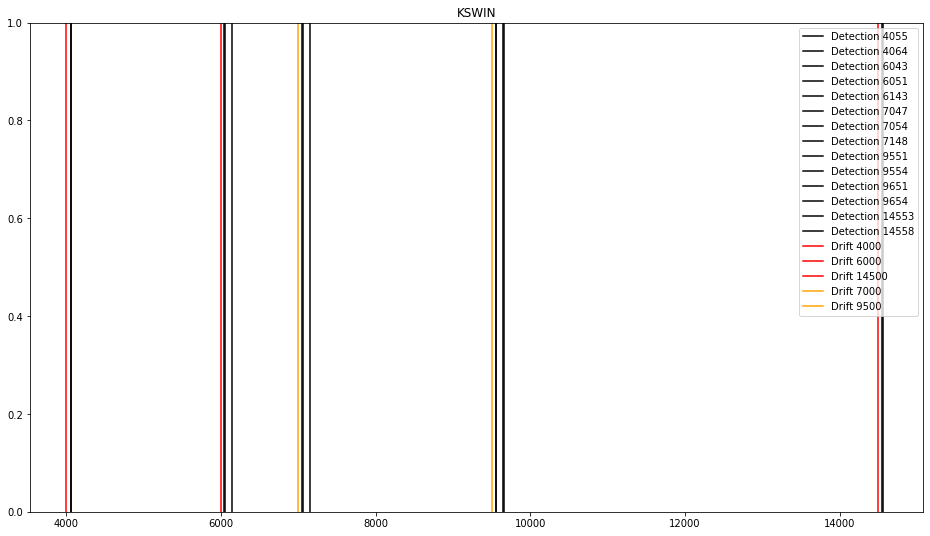

In [68]:
plt.figure(figsize = (16,9))
#plt.plot(uncertainties, label = 'uncertainty')
for i in ks_drifts:
    plt.axvline(i, color = 'black', label = 'Detection {}'.format(i))
    
for i in relevant_drift_points:
    plt.axvline(i, color = 'red', label = 'Drift {}'.format(i))
    
for i in irrelevant_drift_points:
    plt.axvline(i, color = 'orange', label = 'Drift {}'.format(i))

plt.title('KSWIN')
plt.legend()
plt.show()

In [69]:
errors = results['raw']['adwin_error']['errors']
errors_rolling = errors.rolling(window = 50).mean()
det_drifts = adwin_error

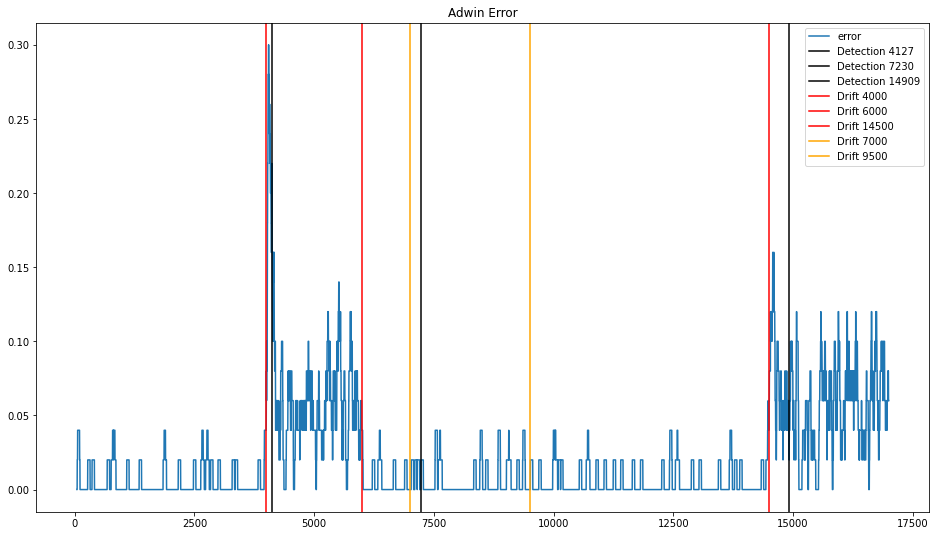

In [70]:
plt.figure(figsize = (16,9))
plt.plot(errors_rolling, label = 'error')
for i in det_drifts:
    plt.axvline(i, color = 'black', label = 'Detection {}'.format(i))
    
for i in relevant_drift_points:
    plt.axvline(i, color = 'red', label = 'Drift {}'.format(i))
    
for i in irrelevant_drift_points:
    plt.axvline(i, color = 'orange', label = 'Drift {}'.format(i))

plt.title('Adwin Error')
plt.legend()
plt.show()

In [71]:
def mean_time_to_detection(true_drifts, detected_drifts):
    detection_time = []
    for i in true_drifts:
        rel_detection = [x for x in detected_drifts if x > i]
        if len(rel_detection) > 0:
            delay = rel_detection[0] - i
            detection_time.append(delay)
    result = np.mean(detection_time)
    return np.round(result, 1)

In [72]:
def number_false_alarms(true_drifts, detected_drifts):
    counter = 0
    detections = np.array(detected_drifts)
    
    if (detections[detections < true_drifts[0]].shape[0] > 0):
        counter += detections[detections < true_drifts[0]].shape[0]
        #print(counter)
        
    for i, v in enumerate(true_drifts[:-1]):
        #print(detections[(detections > true_drifts[i]) & (detections < true_drifts[i+1])])
        value = detections[(detections > true_drifts[i]) & (detections < true_drifts[i+1])].shape[0] - 1 
        counter += max(value, 0)
        #print(counter)
        
    if (detections[detections > true_drifts[-1]].shape[0] > 0):
        #print(true_drifts[-1])
        counter += (detections[detections > true_drifts[-1]].shape[0] - 1)
        
    #print(counter)
    return int(counter)

In [73]:
def missed_detection_count(true_drifts, detected_drifts):
    counter = 0
    detections = np.array(detected_drifts)
        
    for i, v in enumerate(true_drifts[:-1]):
        #print(detections[(detections > true_drifts[i]) & (detections < true_drifts[i+1])])
        value = detections[(detections > true_drifts[i]) & (detections < true_drifts[i+1])].shape[0]
        if value == 0:
            counter += 1
        #print(counter)
        
    if (detections[detections > true_drifts[-1]].shape[0] == 0):
        #print(true_drifts[-1])
        counter += 1

    #print(counter)
    return int(counter)

In [74]:
detections = {}
detections['adwin_uncertainty'] = detected_drifts
detections['kswin'] = ks_drifts
detections['adwin_error'] = adwin_error

In [75]:
results_detection = {}

for i in detections.keys():
    
    det_drifts = detections[i]
    results_local = {}
    results_local['MeanTimeDetection'] = mean_time_to_detection(relevant_drift_points, det_drifts)
    results_local['FalseAlarmCount'] = number_false_alarms(relevant_drift_points, det_drifts)
    results_local['MissedDetectionCount'] = missed_detection_count(relevant_drift_points, det_drifts)
    
    results_detection[i] = results_local

In [76]:
pd.DataFrame(results_detection)

,adwin_uncertainty,kswin,adwin_error
MeanTimeDetection,247.3,50.3,588.7
FalseAlarmCount,0.0,11.0,0.0
MissedDetectionCount,0.0,0.0,0.0


In [77]:
results.keys()

dict_keys(['metrics', 'errors', 'drifts', 'raw'])

In [78]:
raw_dict = results['raw']

In [51]:
raw = raw_dict
uncertainties = raw['adwin_uncertainty 0']['uncertainties']
detected_drifts = detections['adwin_uncertainty']
ks_drifts = detections['kswin']
adwin_drifts = detections['adwin_error']

rel_drift_points = np.array([7000,9000,17500])
irrel_drift_points = np.array([10000,12500])
stream_training_set_size = 20000 * 0.15
shift_rel_drift_points = (rel_drift_points - stream_training_set_size).astype(int)
shift_irrel_drift_points = (irrel_drift_points - stream_training_set_size).astype(int)

relevant_drift_points = [i for i in shift_rel_drift_points if i>0]
irrelevant_drift_points = [i for i in shift_irrel_drift_points if i>0]

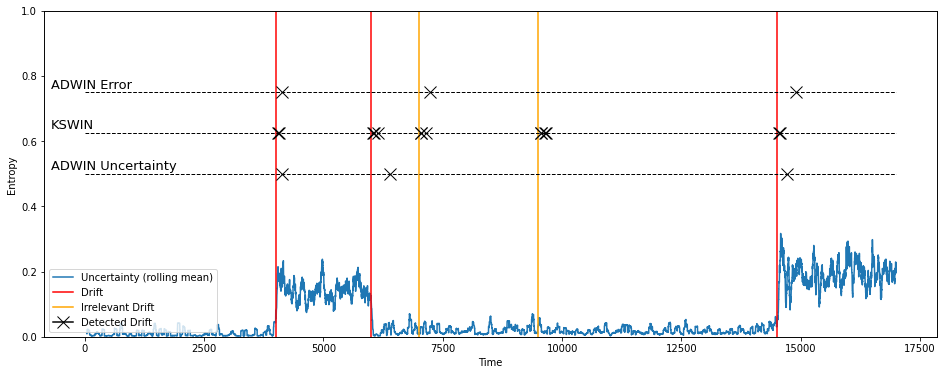

In [58]:
rolling_unc = pd.Series(uncertainties).rolling(window = 50).mean()

fig, ax1 = plt.subplots(figsize = (16,6))
lns1 = ax1.plot(rolling_unc, label = 'Uncertainty (rolling mean)')
ax1.set_ylim([0,1])
ax1.set_ylabel('Entropy')
ax1.set_xlabel('Time')

ax2 = ax1.twinx()

ax2.hlines(1, 0, rolling_unc.shape[0], color = 'black', ls = '--', linewidth = 1)

lns4 = ax2.plot(detected_drifts[0],1, marker='x', color='black', markersize=12, label = 'Detected Drift')
for i in detected_drifts[1:]:
    ax2.plot(i,1, marker='x', color='black', markersize=12)
    #plt.axvline(i, color = 'black', label = 'Detection {}'.format(i))
ax2.text(-700, 1.1, r'ADWIN Uncertainty', fontsize=13)
    
ax2.hlines(2, 0, rolling_unc.shape[0], color = 'black', ls = '--', linewidth = 1)
for i in ks_drifts:
    ax2.plot(i,2 , marker='x', color='black', markersize=12)
ax2.text(-700, 2.1, r'KSWIN', fontsize=13)
    
ax2.hlines(3, 0, rolling_unc.shape[0], color = 'black', ls = '--', linewidth = 1)
for i in adwin_drifts:
    ax2.plot(i,3 , marker='x', color='black', markersize=12)
ax2.text(-700, 3.1, r'ADWIN Error', fontsize=13)
    
ax2.set_ylim([-3,5])
ax2.get_yaxis().set_visible(False)
    
lns2 = ax1.axvline(relevant_drift_points[0], color = 'red', label = 'Drift')    
for i in relevant_drift_points[1:]:
    ax1.axvline(i, color = 'red')

lns3 = ax1.axvline(irrelevant_drift_points[0], color = 'orange', label = 'Irrelevant Drift')     
for i in irrelevant_drift_points[1:]:
    ax1.axvline(i, color = 'orange')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=3)
    
#plt.title('Adwin Uncertainty')
#ax1.legend()
plt.show()

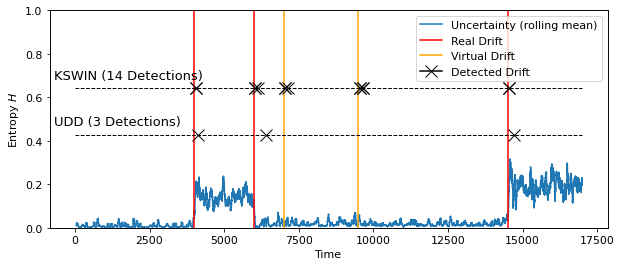

In [81]:
rolling_unc = pd.Series(uncertainties).rolling(window = 50).mean()

fig, ax1 = plt.subplots(figsize = (10,4))
lns1 = ax1.plot(rolling_unc, label = 'Uncertainty (rolling mean)')
ax1.set_ylim([0,1])
ax1.set_ylabel('Entropy $H$')
ax1.set_xlabel('Time')

ax2 = ax1.twinx()

ax2.hlines(0, 0, rolling_unc.shape[0], color = 'black', ls = '--', linewidth = 1)

lns4 = ax2.plot(detected_drifts[0],0, marker='x', color='black', markersize=12, label = 'Detected Drift')
for i in detected_drifts[1:]:
    ax2.plot(i,0, marker='x', color='black', markersize=12)
    #plt.axvline(i, color = 'black', label = 'Detection {}'.format(i))
ax2.text(-700, 0.3, r'UDD ({} Detections)'.format(len(detected_drifts)), fontsize=13)
    
ax2.hlines(1.5, 0, rolling_unc.shape[0], color = 'black', ls = '--', linewidth = 1)
for i in ks_drifts:
    ax2.plot(i,1.5 , marker='x', color='black', markersize=12)
ax2.text(-700, 1.8, r'KSWIN ({} Detections)'.format(len(ks_drifts)), fontsize=13)
    
#ax2.hlines(3, 0, rolling_unc.shape[0], color = 'black', ls = '--', linewidth = 1)
#for i in adwin_drifts:
#    ax2.plot(i,3 , marker='x', color='black', markersize=12)
#ax2.text(-700, 3.1, r'ADWIN Error', fontsize=13)
    
ax2.set_ylim([-3,4])
ax2.get_yaxis().set_visible(False)
    
lns2 = ax1.axvline(relevant_drift_points[0], color = 'red', label = 'Real Drift')    
for i in relevant_drift_points[1:]:
    ax1.axvline(i, color = 'red')

lns3 = ax1.axvline(irrelevant_drift_points[0], color = 'orange', label = 'Virtual Drift')     
for i in irrelevant_drift_points[1:]:
    ax1.axvline(i, color = 'orange')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0)

plt.rcParams.update({'font.size': 11})

fig.savefig("Mixed_Detection.pdf", bbox_inches='tight')

#plt.title('Adwin Uncertainty')
#ax1.legend()
plt.show()

In [55]:
errors = results['raw']['adwin_error']['errors']
errors_rolling = errors.rolling(window = 50).mean()
det_drifts = adwin_drifts

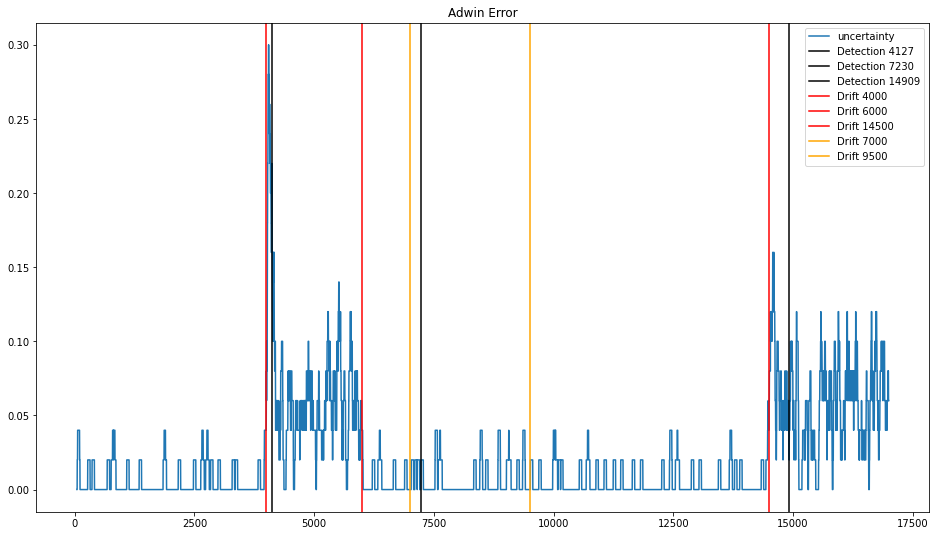

In [56]:
plt.figure(figsize = (16,9))
plt.plot(errors_rolling, label = 'uncertainty')
for i in det_drifts:
    plt.axvline(i, color = 'black', label = 'Detection {}'.format(i))
    
for i in relevant_drift_points:
    plt.axvline(i, color = 'red', label = 'Drift {}'.format(i))
    
for i in irrelevant_drift_points:
    plt.axvline(i, color = 'orange', label = 'Drift {}'.format(i))

plt.title('Adwin Error')
plt.legend()
plt.show()